## Exercise Sheet 7: Variational Autoencoders

In [2]:
import os
import random
import numpy as np
import seaborn as sns

# Import Pytorch, Sklearn
import torch 
import torch.nn as nn
from torch.nn import functional as F

# Load FashionMNIST dataset
from torchvision import datasets, transforms


import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

# set figure size
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [3]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
config_dict = {
    'num_epochs': 5,
    'batch_size': 128,
    'latent_dim': 64,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'mse_weight': 1.0,
    'kl_weight': 0.0001,
    'ckpt_path': 'vae.pth',
    'mode': 'train', # train or test
}

EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


### Define Variational Autoencoder Architecture

In [4]:
class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        # Decoder
        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])

        # Fully connected layers for learning representations
        self.fc_latent = nn.Linear(in_features=self.latent_dim + self.embed_dim, out_features=512, bias=True)
        self.fc_mean = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)
        self.fc_var = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)

        # Activation functions
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        # Encoder network
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)

        # Flatten
        x = torch.reshape(x, (x.shape[0], -1))
        # Fully connected layers
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var
    
    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z

### Task 1: Training a Variational Autoencoder on MNIST

In [5]:
# Task 1.1 Download the MNIST dataset
mean = (0.1307,)
std = (0.3081,)

# Define the transformation
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)),
        transforms.RandomRotation(5),
        transforms.Normalize(mean, std)
    ])

# Download and load the training dataset
trainset = datasets.MNIST(DATA_DIR, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test dataset
testset = datasets.MNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

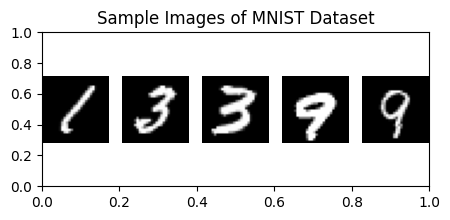

<Figure size 640x480 with 0 Axes>

In [6]:
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Sample Images of MNIST Dataset')
# place it on GPU if available
dataiter = iter(trainloader) 
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'mnist_dataset_images.png')

In [7]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def vae_loss(x, x_recon, mean, log_var, mse_weight=1., kl_weight=1e-3):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # Mean Squared Error Loss
    mse = torch.square(x - x_recon)
    # KL Divergence Loss
    kl_div = 0.5 * torch.sum(torch.exp(log_var) + torch.square(mean) - log_var - 1, dim=1)
    loss = mse_weight * torch.mean(mse) + kl_weight * torch.mean(kl_div)
    return loss

In [8]:
def reconstruction_loss(x, x_recon):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # MSE Loss -- Reconstruction loss
    mse = torch.mean((x - x_recon) ** 2)
    return torch.mean(mse)

In [9]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def regularization_loss(mean, log_var):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    kl_div = 0.5 * torch.sum(torch.exp(log_var) + torch.square(mean) - log_var - 1, dim=1)
    return torch.mean(kl_div)

In [10]:
# Task 1.2 Implement the VAE model
vae = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [11]:
def train(model, optimizer, epochs, trainloader, device, loss_type='total_loss'):
    """
    Train VAE model and plot sample image per class after each epoch.

    Args:
        model (nn.Module): VAE model.
        optimizer (torch.optim): Optimizer.
        epochs (int): Number of epochs.
        trainloader (DataLoader): Training data loader.
        device (torch.device): Which device to use (cuda or cpu).
    
    Returns:
        None
    """
    training_losses = []

    model.train()
    for epoch in range(epochs):
        for step, (images, labels) in enumerate(trainloader):
            x = images.to(device)
            y = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mean, log_var = model(x, y)

            # Compute loss
            if loss_type == 'total_loss':
                loss = vae_loss(x, x_recon, mean, log_var)
            elif loss_type == 'bce_loss':
                loss = F.binary_cross_entropy(x_recon, x, reduction='sum') # alternative to MSE with sigmoid activation
            elif loss_type == 'mse_loss':
                loss = reconstruction_loss(x, x_recon)
            elif loss_type == 'kl_loss':
                loss = regularization_loss(mean, log_var)
            else:
                raise ValueError("Invalid loss type. Choose from ['bce_loss', 'total_loss', 'reconstruction_loss', 'regularization_loss']")
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # append los per step
            training_losses.append(loss.item()) 

            # ---- Print training loss per 10 Steps ----
            if (step + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Step [{step + 1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # ---- Plot sample image per class ----
        sample_images = []
        for i in range(10):
            sample_images.append(model.sample(i, device).cpu().detach().numpy())

        plt.figure(figsize=(10, 1))
        plt.suptitle(f'Epoch {epoch + 1}/{epochs} - Sample Images')
        
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()
        plt.savefig(RESULTS_DIR + f'sample_images_epoch_{epoch + 1}.png')
    
    return training_losses

Epoch [1/5], Step [100/469], Loss: 0.8282
Epoch [1/5], Step [200/469], Loss: 0.6877
Epoch [1/5], Step [300/469], Loss: 0.6558
Epoch [1/5], Step [400/469], Loss: 0.6723


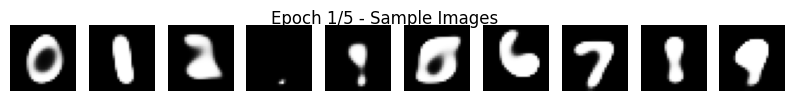

Epoch [2/5], Step [100/469], Loss: 0.6623
Epoch [2/5], Step [200/469], Loss: 0.6432
Epoch [2/5], Step [300/469], Loss: 0.6330
Epoch [2/5], Step [400/469], Loss: 0.6278


<Figure size 640x480 with 0 Axes>

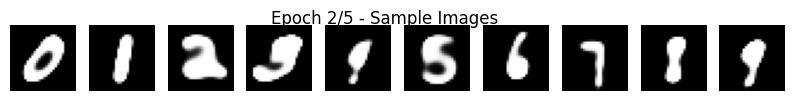

Epoch [3/5], Step [100/469], Loss: 0.6037
Epoch [3/5], Step [200/469], Loss: 0.6397
Epoch [3/5], Step [300/469], Loss: 0.6424
Epoch [3/5], Step [400/469], Loss: 0.6119


<Figure size 640x480 with 0 Axes>

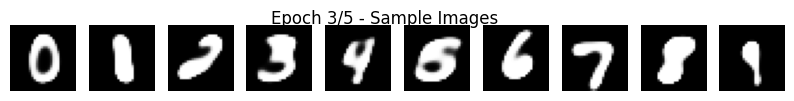

Epoch [4/5], Step [100/469], Loss: 0.6248
Epoch [4/5], Step [200/469], Loss: 0.6050
Epoch [4/5], Step [300/469], Loss: 0.6158
Epoch [4/5], Step [400/469], Loss: 0.6118


<Figure size 640x480 with 0 Axes>

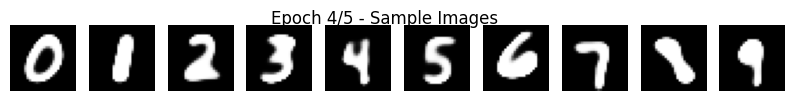

Epoch [5/5], Step [100/469], Loss: 0.6228
Epoch [5/5], Step [200/469], Loss: 0.6343
Epoch [5/5], Step [300/469], Loss: 0.6305
Epoch [5/5], Step [400/469], Loss: 0.6701


<Figure size 640x480 with 0 Axes>

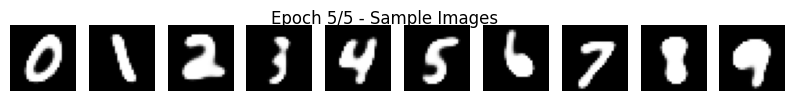

<Figure size 640x480 with 0 Axes>

In [12]:
# train the VAE model
training_losses = train(vae, optimizer, EPOCHS, trainloader, device, loss_type='total_loss')

### Task 1.3: Plot the training curve for the VAE model

In [13]:
# Task 1.3 Plot the training curve (loss) of the VAE model with steps on x-axis and loss on y-axis

def plot_loss_curve(training_losses, figsize=(5, 3), file_name='training_loss_curve'):
    """ Plot the training loss curve."""
    plt.figure(figsize=figsize)
    plt.plot(training_losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')

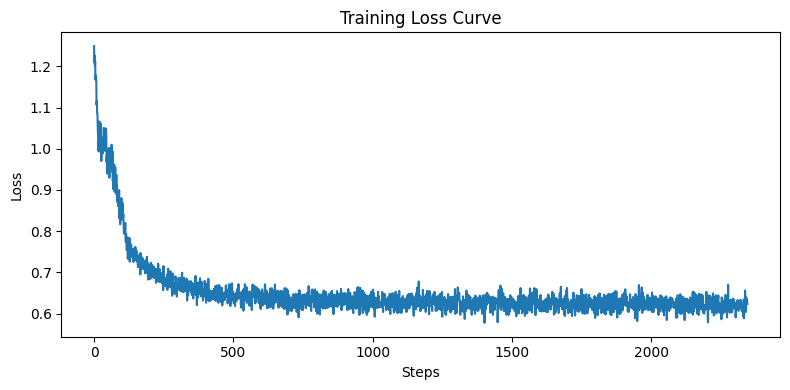

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 4), file_name='vae_training_loss_curve')

## Task 2: Visualize the latent space


### Task 2.1: Train VAE with MSE Loss

In [15]:
# Task 2.1 train VAE again using only reconstruction loss
vae_rec = VAE(latent_dim=2).to(device)

optimizer = torch.optim.Adam(vae_rec.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# train the VAE model only with MSE reconstruction loss
training_losses = train(vae_rec, optimizer, EPOCHS, trainloader, device, loss_type='mse_loss')

# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 4), file_name='vae_mse_rec_training_loss_curve')

Epoch [1/5], Step [100/469], Loss: 0.7909


### Task 2.1.2: Train VAE with KL Loss

Epoch [1/5], Step [100/469], Loss: 0.0001
Epoch [1/5], Step [200/469], Loss: 0.0000
Epoch [1/5], Step [300/469], Loss: 0.0000
Epoch [1/5], Step [400/469], Loss: 0.0000


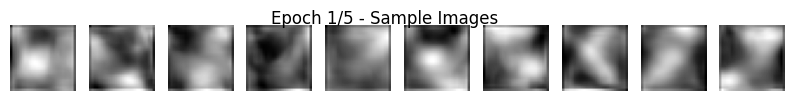

Epoch [2/5], Step [100/469], Loss: 0.0000
Epoch [2/5], Step [200/469], Loss: 0.0000
Epoch [2/5], Step [300/469], Loss: 0.0000
Epoch [2/5], Step [400/469], Loss: 0.0000


<Figure size 640x480 with 0 Axes>

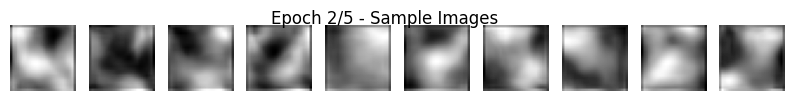

Epoch [3/5], Step [100/469], Loss: 0.0000
Epoch [3/5], Step [200/469], Loss: 0.0000
Epoch [3/5], Step [300/469], Loss: 0.0000
Epoch [3/5], Step [400/469], Loss: 0.0000


<Figure size 640x480 with 0 Axes>

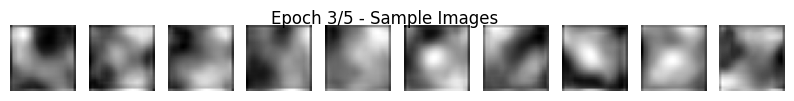

Epoch [4/5], Step [100/469], Loss: 0.0000
Epoch [4/5], Step [200/469], Loss: 0.0000
Epoch [4/5], Step [300/469], Loss: 0.0000
Epoch [4/5], Step [400/469], Loss: 0.0000


<Figure size 640x480 with 0 Axes>

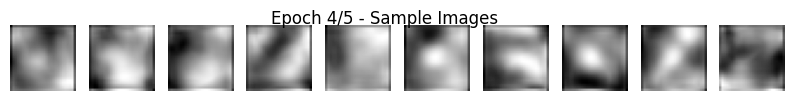

Epoch [5/5], Step [100/469], Loss: 0.0000
Epoch [5/5], Step [200/469], Loss: 0.0000
Epoch [5/5], Step [300/469], Loss: 0.0000
Epoch [5/5], Step [400/469], Loss: 0.0000


<Figure size 640x480 with 0 Axes>

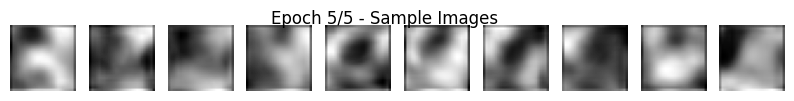

<Figure size 640x480 with 0 Axes>

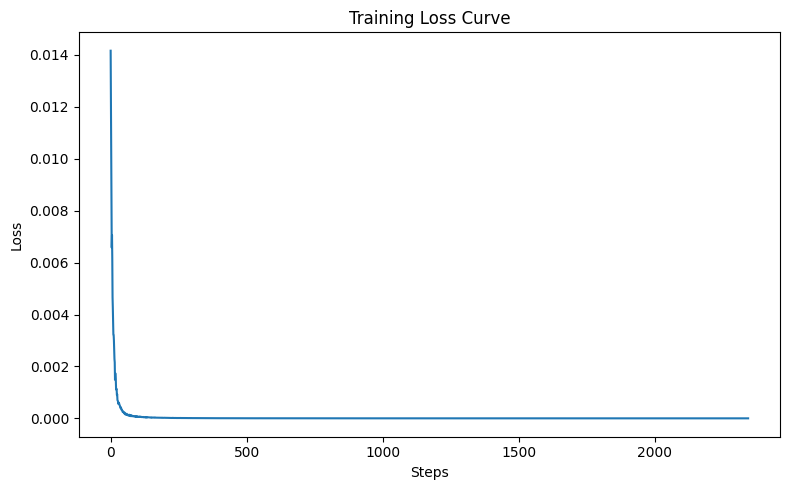

<Figure size 640x480 with 0 Axes>

In [ ]:
# Task 2.2 train VAE again using only regularization loss (KL-divergence)
vae_reg = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae_reg.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train the model
training_losses = train(vae_reg, optimizer, EPOCHS, trainloader, device, loss_type='kl_loss')

# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 4), file_name='vae_reg_training_loss_curve')

**What can you observe?**

Training only with KL-Loss
* The KL-Loss term structures the latent space
* VAE focuses only on making latent space distribution match the prior (standard normal distribution)
* This leads to very blurry output images since KL-Divergence encourages the latent space to be as close as possible to the prior distribution which may lead to loss of detail
* Without a reconstruction loss on pixel-level e.g. MSE loss the decoder learns to generate "average" image details that somwhat resemble the training data but lack sharpness and high frequency details since there is no encouragement to learn further image details


### Task 2.3: Train VAE with Total Loss (MSE + KL-Div Loss)

Epoch [1/5], Step [100/469], Loss: 0.7946
Epoch [1/5], Step [200/469], Loss: 0.7046
Epoch [1/5], Step [300/469], Loss: 0.6653
Epoch [1/5], Step [400/469], Loss: 0.6607


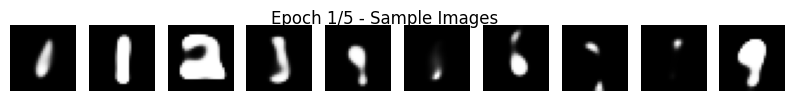

Epoch [2/5], Step [100/469], Loss: 0.6558
Epoch [2/5], Step [200/469], Loss: 0.6259
Epoch [2/5], Step [300/469], Loss: 0.6239
Epoch [2/5], Step [400/469], Loss: 0.6498


<Figure size 640x480 with 0 Axes>

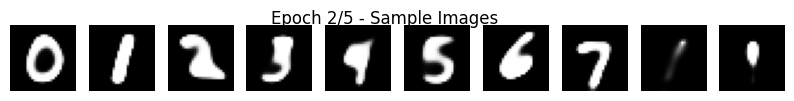

Epoch [3/5], Step [100/469], Loss: 0.6369
Epoch [3/5], Step [200/469], Loss: 0.6294
Epoch [3/5], Step [300/469], Loss: 0.6170
Epoch [3/5], Step [400/469], Loss: 0.6290


<Figure size 640x480 with 0 Axes>

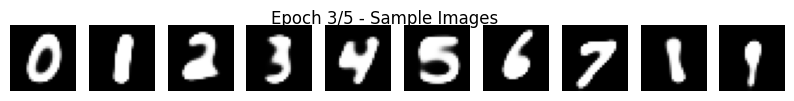

Epoch [4/5], Step [100/469], Loss: 0.6328
Epoch [4/5], Step [200/469], Loss: 0.6456
Epoch [4/5], Step [300/469], Loss: 0.6061
Epoch [4/5], Step [400/469], Loss: 0.6080


<Figure size 640x480 with 0 Axes>

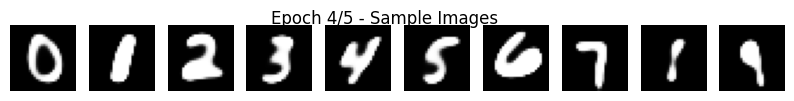

Epoch [5/5], Step [100/469], Loss: 0.6225
Epoch [5/5], Step [200/469], Loss: 0.6235
Epoch [5/5], Step [300/469], Loss: 0.6332
Epoch [5/5], Step [400/469], Loss: 0.6266


<Figure size 640x480 with 0 Axes>

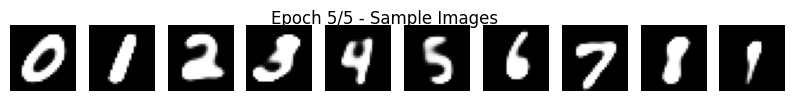

<Figure size 640x480 with 0 Axes>

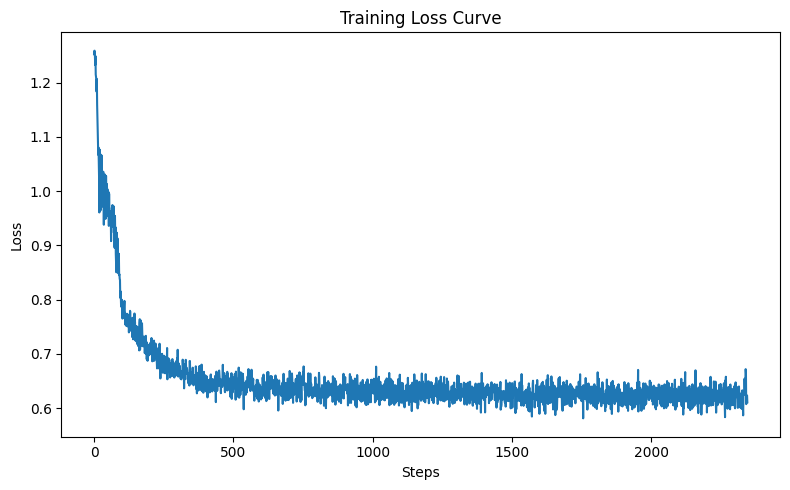

<Figure size 640x480 with 0 Axes>

In [ ]:
# Task 2.3 train VAE again using both reconstruction and regularization loss
vae_t = VAE(latent_dim=2).to(device)


optimizer = torch.optim.Adam(vae_t.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
training_losses = train(vae_t, optimizer, EPOCHS, trainloader, device, loss_type='total_loss')

# Plot the loss curve
plot_loss_curve(training_losses, figsize=(8, 5), file_name='vae_total_training_loss_curve')

In [ ]:
import tqdm


def plot_latent_space(model, dataloader, device=None, file_name='vae_latent_space'):
    """ Posterior sampling based on a given MNIST test image. Extract the latent space and plot it using t-SNE.

    Args:
        vae (nn.Module): VAE model.
        dataloader (DataLoader): Dataloader to use for sampling from the true data distribution.
        n (int): Number of samples to plot.
        figsize (int): Size of the figure.
        method (str): Method to use for projecting the latent space to 2D. Should be 'TSNE'.
        device (torch.device): Device to use for tensor operations.

    Returns:
        None
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set the model to evaluation mode
    model.eval()

    # Sample a large number of points from the true data distribution and encode to obtain latent space samples
    latents = []
    labels = []

    for (x, y) in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = model.sample_latent(x, y)
        latents.append(z.detach().cpu().numpy())
        labels.append(y.detach().cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Plot the latent space as a 2D scatter plot
    sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels, palette='tab10')
    plt.title('Latent Variable Space')
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')


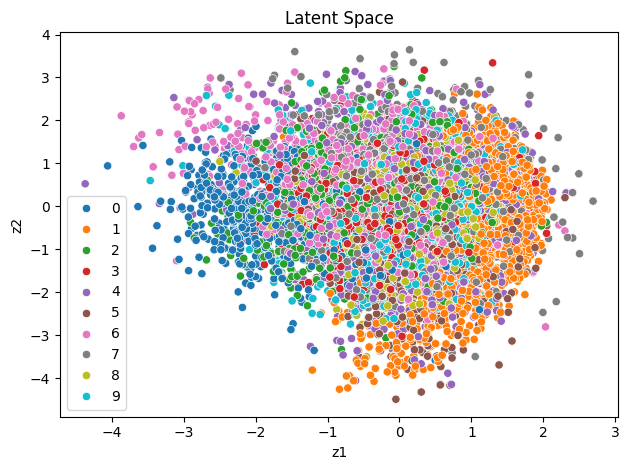

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space
plot_latent_space(vae, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_latent_space')

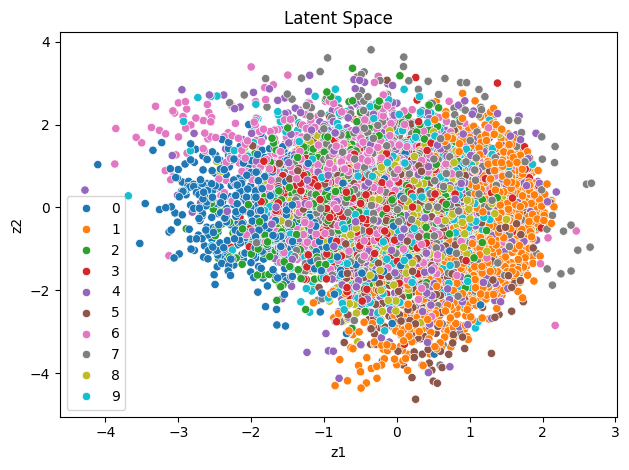

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space for all three models -- reconstruction loss only
plot_latent_space(vae_rec, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_rec_latent_space')

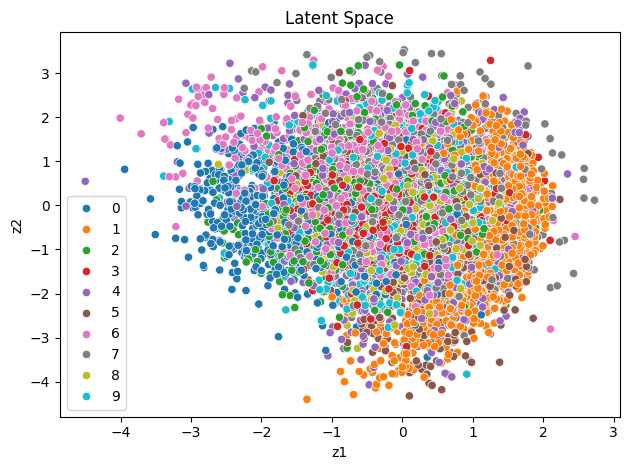

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space for all three models -- regularization loss only
plot_latent_space(vae_reg, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_reg_latent_space')

**Why can we observe a more homegenous distribution of all classes in the above graph using a loss with KL-Divergence only?**

When training a Variational Autoencoder (VAE) using only the KL-Divergence loss, we observe a more **homogeneous distribution** of all classes in the latent space. This phenomenon occurs due to the nature and purpose of the KL-Divergence term in the VAE objective function.
The KL-Divergence loss in VAEs serves as a **regularizer**, encouraging the learned latent distribution $q(z|x)$ to match a predefined **prior distribution** $p(z)$, typically a **standard Gaussian** (mean 0, variance 1). This loss is calculated as:
```KL(q(z|x) || p(z)) = 0.5 * sum(exp(log_var) + mean^2 - log_var - 1)```
Where 'mean' and 'log_var' are the outputs of the encoder network. <br>

<br>
When only this loss is used: <br>
<br>
Encodings for all inputs, regardless of their class, are pushed towards a standard Gaussian distribution in the latent space.
The model is penalized for creating distinct clusters or patterns for different classes.
There's no incentive to preserve class-specific or detailed information in the latent space.
<br>
This results in: <br>
<br>
A latent space where all encodings are densely packed around the origin, following a Gaussian distribution.
Loss of class-specific information and structure in the latent representations.
Difficulty in decoding meaningful or class-specific outputs from this homogeneous latent space. <br>
<br>
While this homogeneous distribution might seem counterintuitive, it's important to understand that the KL-Divergence alone is not sufficient for training a useful VAE. In a properly trained VAE, we use a combination of reconstruction loss and KL-Divergence loss:<br>
<br>
Reconstruction loss (e.g., MSE or BCE) encourages the model to encode and decode information accurately.
KL-Divergence loss ensures a well-structured, continuous latent space that allows for smooth interpolation and generation.<br>
<br>
The balance between these two losses is crucial:<br>
<br>
* It allows the model to preserve enough information for accurate reconstruction.
* It ensures the latent space is well-organized and follows a known distribution, enabling generation of new samples.
* It facilitates smooth interpolation between different classes in the latent space.
<br>
<br>
In practice, the weight of the KL-Divergence term is often treated as a hyperparameter (β in β-VAE formulations) to control the trade-off between reconstruction quality and latent space regularity.
By using only the KL-Divergence loss, we lose the model's ability to perform meaningful reconstructions or maintain class-specific information, resulting in the observed homogeneous distribution in the latent space.

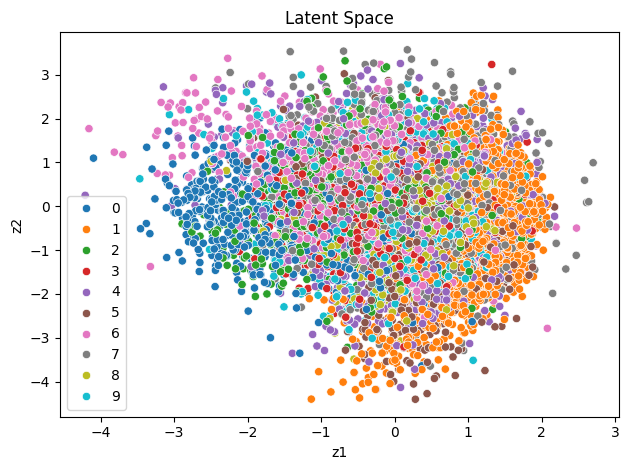

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space -- total loss
plot_latent_space(vae_t, testloader, n=1000, figsize=5, device=device, file_name='vae_t_latent_space')

**Why can we observe more clustering in the latent space using Reconstruction loss with Regularization loss (KL-Divergence)?**

When optimizing a VAE with both reconstruction loss and KL-Divergence loss, we observe a latent space that balances local structure with global constraints: <br> 
<br> 
**Local Structure:** <br> 
The reconstruction loss encourages the model to preserve information necessary for accurate decoding. This leads to the formation of local clusters in the latent space, where similar inputs are encoded near each other.<br> 
<br> 
**Global Distribution:** <br> 
The KL-Divergence loss pushes the overall distribution of encodings towards a standard Gaussian (typically N(0, I)). This ensures the latent space is densely packed near the origin and follows a known distribution.

The resulting latent space exhibits these characteristics:

* Distinct clusters that the decoder can meaningfully interpret.
* A global structure that adheres to the prior distribution (usually Gaussian).
Smooth transitions between clusters, allowing for meaningful interpolation.

<br> 
This balance enables several useful properties: <br> 
<br> 
**Sampling:**
<br> 
Vectors sampled from the prior distribution N(0, I) can be successfully decoded into realistic outputs. <br> 
<br> 
**Interpolation:** 
<br> 
Smooth interpolation between different points in the latent space is possible, as there are no abrupt gaps between clusters.<br> 
<br> 
**Vector Arithmetic:** <br> 
Simple operations in the latent space can yield meaningful results: <br> 
<br> 
**Interpolation:** 
<br> 
To generate a sample halfway between two inputs, one can average their latent representations and decode the result.
Feature Addition/Subtraction: By encoding samples with and without a specific feature (e.g., glasses on faces), you can create a "feature vector". Adding or subtracting this vector from other latent representations can add or remove the feature in the decoded output.

In [ ]:
# Plot a grid of samples produced by fixing one latent variable and varying the other

def plot_latent_traversal(vae, device, n=10):
    """ Plot a grid of samples produced by fixing one latent variable and varying the other.

    Args:
        vae (nn.Module): VAE model.
        device (torch.device): Device to use for tensor operations.
        n (int): Number of samples to plot.

    Returns:
        None
    """
    vae.eval()

    # Sample a latent variable based on a standard normal distribution
    z = torch.randn((1, vae.latent_dim), device=device)
    z = z.repeat(n, 1)

    # Plot 10x10 grid of samples
    for i in range(0, n):
        # Select fixed label
        y = torch.tensor([i] * n, device=device)
        
        # Decode the latent variable
        with torch.no_grad():
            samples = vae.decode(z, y)

        # Plot the samples
        plt.figure(figsize=(n, 1))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
            plt.axis('off')
            # add class label
            plt.title(f'Class: {y[i].item()}')
        plt.show()
        plt.savefig(RESULTS_DIR + f'vae_latent_traversal_{i}.png')


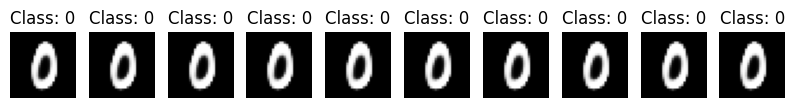

<Figure size 640x480 with 0 Axes>

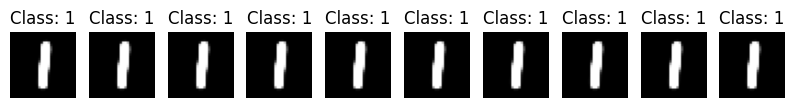

<Figure size 640x480 with 0 Axes>

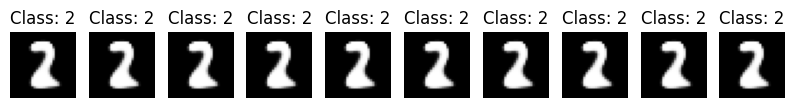

<Figure size 640x480 with 0 Axes>

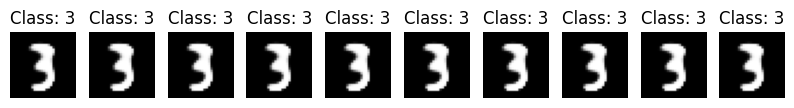

<Figure size 640x480 with 0 Axes>

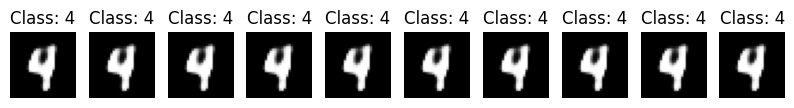

<Figure size 640x480 with 0 Axes>

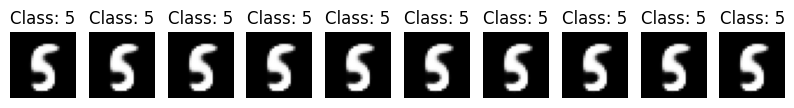

<Figure size 640x480 with 0 Axes>

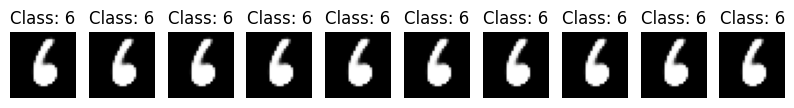

<Figure size 640x480 with 0 Axes>

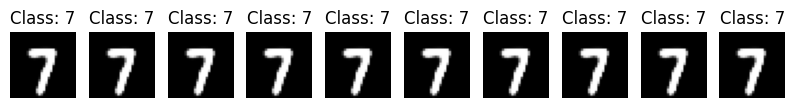

<Figure size 640x480 with 0 Axes>

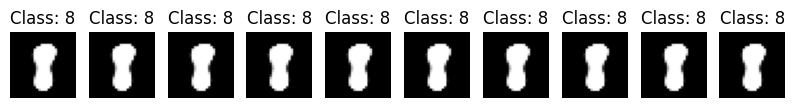

<Figure size 640x480 with 0 Axes>

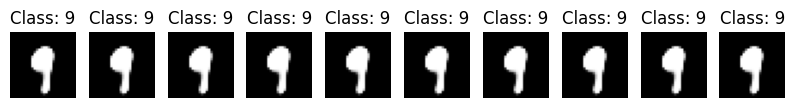

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the latent traversal
plot_latent_traversal(vae, device, n=10)

## Task 3: Anomaly Detection using a Variational Autoencder


### Task 3.1: Data Preparation for Fashion MNIST Dataset

In [ ]:
# Task 3.1: Download the Fashion MINST dataset
mean = (0.1307,)
std = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize(mean, std)])

# Download and load the training dataset
fashion_trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform)
fashion_trainloader = torch.utils.data.DataLoader(fashion_trainset, batch_size=BATCH_SIZE, shuffle=True)

fashion_testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=BATCH_SIZE, shuffle=False)

# Create a mixed dataset with 50% MNIST and 50% Fashion MNIST
mnist_indices = np.random.choice(len(trainset), len(trainset) // 2, replace=False)
fashion_indices = np.random.choice(len(fashion_trainset), len(fashion_trainset) // 2, replace=False)

# Create a mixed dataset based on indices
mixed_trainset = torch.utils.data.ConcatDataset([
    torch.utils.data.Subset(trainset, mnist_indices),
    torch.utils.data.Subset(fashion_trainset, fashion_indices)
])



NameError: name 'transforms' is not defined

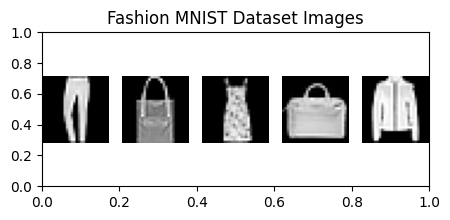

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot 5 sample images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Fashion MNIST Dataset Images')

dataiter = iter(fashion_trainloader)
for i in range(num_images):
    images, _ = next(dataiter)

    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'fashion_mnist_dataset_images.png')

In [ ]:
def compare_reconstruction_loss(vae, fashion_testloader, mnist_testloader, device, file_name='reconstruction_loss_comparison'):
    """ Anomaly detection identifies data points that deviate significantly from the norm
        Compare the reconstruction loss between MNIST and Fashion MNIST datasets.

    Args:
        vae (nn.Module): VAE model.
        trainloader (DataLoader): Training data loader.
        testloader (DataLoader): Test data loader.
        device (torch.device): Which device to use (cuda or cpu).

    Returns:
        None
    """
    vae.eval()
    imgs_mnist = []
    imgs_fashion = []
    rec_loss_mnist = []
    rec_loss_fashion = []

    # Compute the reconstruction loss for MNIST dataset
    for i, (images, labels) in enumerate(mnist_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, _, _ = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_mnist.append(loss.item())
        imgs_mnist.append(images.cpu().detach().numpy())

    # Compute the reconstruction loss for Fashion MNIST dataset
    for i, (images, labels) in enumerate(fashion_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, _, _ = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_fashion.append(loss.item())
        imgs_fashion.append(images.cpu().detach().numpy())

    # Plot 10 sample MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_mnist[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_mnist[:10], color='red', linewidth=2)

    # MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_mnist[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_mnist[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes) # display the reconstruction loss value below the image
        ax.axis('off')

    plt.savefig(f'results/{file_name}_mnist.png')
    plt.show()

    # Plot 10 sample Fashion MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('Fashion MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_fashion[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_fashion[:10], color='red', linewidth=2)

    # Fashion MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_fashion[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_fashion[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes)
        ax.axis('off')

    plt.savefig(f'results/{file_name}_fashion_mnist.png')
    plt.show()


In [ ]:
# Compare the reconstruction loss between MNIST and Fashion MNIST datasets
# Use samples from MNIST handwritten digit dataset and the MNIST. fashion dataset to showcase the difference in reconstruction loss. Plot 10 samples of each dataset and their corresponding reconstruction loss.
compare_reconstruction_loss(vae, fashion_testloader, testloader, device, file_name='reconstruction_loss_comparison')